# Discover SWOT lakeSP product by using SWOT database 


![](https://img.shields.io/badge/CNES-tutorial-%20?color=blue&labelColor=grey)

_Authors: Damien Desroches, Mathilde Siméon (CNES)_
 
### Objectives
This tutorial explains  
* How to access to the SWOT hydrology database
* How to use if for lake multitemporal studies

### Requirements
1. **Run the notebook in the swot expertise center** to use the hydro database api 
3. Run the notebook in `ceswot` environment


### Content
* [Product overview](#The-LakeSP-product)
* [BD hydro manipulation](#BD-hydro-manipulation)


## The LakeSP product

### Description
The lakeSP product is a vectorial product provided in shapefile format. It contains aggregated variables along each water bodies which is not identified as a river.
A link is done between SWOT observations and a global independant lake database in order to identify each lake.
Each lake is identify as a polygon with different attributes, agregating variables from pixel cloud.

<div>
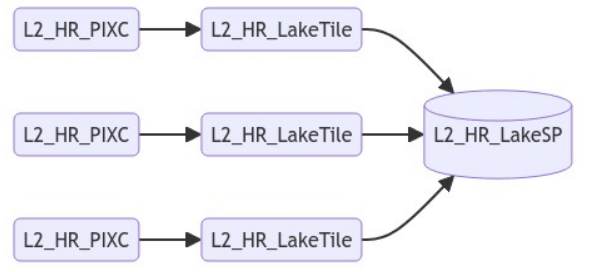
</div>


### When to use it ?

It can be useful for :
- Time monitoring of different lakes over a long period (wse, areas, etc...)
- Study of the shape of the lake and comparison with other sensors
- Identification of new water features
    
### Associated issues
As this product provides full information, is is necessary to consider
- consulting the [ATBD/PDD](https://podaac.jpl.nasa.gov/SWOT?tab=datasets-information) documents to understand what are the different fields in the product and how there are computed
- take into account that there is global method to agregate and combine information from pixel cloud that may not be adapted for your study (complex shape, strong wrong detection, etc...)
- **Lake product may contain features that are not lakes** (especially in the "Unassign" product). Due to their strong backscattering, some areas are wrongly detected as water.

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xr 
from scipy.ndimage import uniform_filter
from shapely.geometry import Polygon
import geopandas as gpd
import shapefile
import matplotlib.animation as animation
from IPython.display import HTML
import hydro_db_api
import datetime
from hydro_db_api import search

In [2]:
import shapely
import folium
from folium.plugins import TimestampedGeoJson

In [3]:
def create_geojson_features(df,param='wse'):
    '''
    df = a pandas geodataframe with 'geometry' and '_time' column
    param= the name of variable column to use
    '''
    features = []
    
    #loop over every observations
    for _, row in df.iterrows():
         # create a feature with a time, an id and style attributes
        if row['geometry'] is not None:
            color=colormap(row[param])
            feature = {
            'type': 'Feature',
            'geometry': shapely.geometry.mapping(row['geometry']),
            'properties': {
               'name':  row['_fuid'],
               'time': row['_time'].strftime("%Y-%m-%dT00:00:00"),
               'tooltip': f"fuid: {row['_fuid']}</br>{param}: {row[param]}" ,
               'style': {'color' : color, 'fillColor' : color,
                          'fillOpacity': 1.0,
                          'opacity': 1.0,
                         },
  
            }
        }
            features.append(feature)
    return {'type': 'FeatureCollection', 'features': features }

## Request the Hydro Database

In [4]:
hydro_db_api.search.list_tables()

['truth_lake',
 'truth_lake_ts',
 'alembic_version',
 'swot_lakesp',
 'swot_riversp_node',
 'swot_riversp_reach',
 'swot_riversp_reach_ts',
 'swot_lakesp_demo',
 'swot_lakesp_demo_ts',
 'swot_lakesp_reproc2024',
 'swot_lakesp_reproc2024_ts',
 'swot_lakesp_diff_reproc2024',
 'swot_lakesp_diff_reproc2024_ts',
 'swot_riversp_node_diff_reproc2024',
 'swot_riversp_node_diff_reproc2024_ts',
 'swot_riversp_reach_diff_reproc2024',
 'swot_riversp_reach_diff_reproc2024_ts',
 'swot_lakesp_diff',
 'swot_lakesp_diff_ts',
 'swot_riversp_node_diff',
 'swot_riversp_node_diff_ts',
 'swot_riversp_reach_diff',
 'swot_riversp_reach_diff_ts',
 'swot_lakesp_dw_loop_sept2024',
 'swot_lakesp_dw_loop_sept2024_ts',
 'swot_riversp_node_reproc2024',
 'swot_riversp_node_reproc2024_ts',
 'swot_riversp_reach_reproc2024',
 'swot_riversp_reach_reproc2024_ts',
 'swot_lakesp_diff_dw_loop_sept2024_ts',
 'swot_lakesp_ts',
 'swot_riversp_node_ts',
 'truth_river_node',
 'truth_river_reach',
 'truth_river_reach_ts',
 'truth_

In [5]:
hydro_db_api.search.list_columns(table='truth_lake_ts')

['_fuid',
 '_time',
 'geometry',
 'height',
 'height_u',
 'wse',
 'wse_u',
 'area_total',
 'area_tot_u',
 'storage',
 'storage_u',
 'partial_f',
 'valid_flag',
 'ice_f']

In [8]:
insitu_sites = hydro_db_api.search.search_features(table='truth_lake',columns=['source_name'])
set(insitu_sites["source_name"])

{'CEHQ',
 'ExtractEO_TP',
 'Hydroquebec',
 'NVE',
 'RCM_TP',
 'SLUM_TP',
 'UdeS',
 'bafu',
 'ceara_wse',
 'citec',
 'eccc_gnss',
 'hydroweb_lake',
 'lake_us',
 'locss',
 'locss_pyrenees',
 'oecs_lake',
 'sertit',
 'sget',
 'smhi',
 'spence',
 'usgs'}

In [9]:
%time
results = hydro_db_api.search.search_features(table='swot_lakesp_reproc2024')
results

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.81 μs


,_fuid,id,wkb_geometry
0,1420020252,1420020252,None
1,1420020272,1420020272,None
2,1420021762,1420021762,None
3,1420021772,1420021772,None
4,1420021782,1420021782,None
...,...,...,...
44720,8221540912,8221540912,None
44721,8221541942,8221541942,None
44722,8221542582,8221542582,None
44723,8221543132,8221543132,None


In [10]:
%time
results = hydro_db_api.search.search_features(table='truth_lake', filtered_by="id='Hydroquebec:7250737532'")
results

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 3.58 μs


,id,wkb_geometry,lake_id,source_name,source_id,name,_fuid,geoid_hght,wse_levelled
0,Hydroquebec:7250737532,POINT (-77.40478 47.72276),7250737532,Hydroquebec,1-12314,Grand Lac Victoria (CMIR),Hydroquebec:7250737532,-36.4343,True


In [11]:
%time
results = hydro_db_api.search.count_observations(table='swot_lakesp_reproc2024_ts',
                                                  group_by=['cycle_number','pass_number'],
                                                  start=datetime.datetime(2023,3,20),
                                                  end=datetime.datetime(2024,4,1))
results

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 3.1 μs


,cycle_number,pass_number,count
0,571,14,2031
1,487,16,688
2,520,22,161
3,486,22,84
4,498,9,6733
...,...,...,...
1131,538,27,207
1132,497,1,25
1133,521,1,34
1134,578,1,31


## Example in Panama

In [12]:
lake_id = '7710070532' #panama


results = hydro_db_api.search.search_observations(table='swot_lakesp_reproc2024_ts',
                                                  start=datetime.datetime(2023,1,1),
                                                  end=datetime.datetime(2024,1,1),
                                                 filtered_by="_fuid='{}'".format(lake_id))
results

,_fuid,_time,geometry,cycle_number,pass_number,wse,wse_u,area_total,area_tot_u,area_geom,...,xtrk_dist,dark_frac,n_overlap,n_shared,partial_f,ice_clim_f,ice_dyn_f,quality_f,xovr_cal_q,pge_version
0,7710070532,2023-04-06 04:04:02,"MULTIPOLYGON (((-79.59197 9.02003, -79.59188 9...",482,9,16.830,0.045,0.221673,0.002281,0.228616,...,-57502.586,0.090259,1,1,0,0,-999,0,0,reproc2024_pgc1
1,7710070532,2023-04-08 03:45:18,"MULTIPOLYGON (((-79.59334 9.01070, -79.59325 9...",484,9,17.168,0.148,0.169094,0.000767,0.138107,...,-57169.754,0.787497,1,1,0,0,-999,1,0,reproc2024_pgc1
2,7710070532,2023-04-09 03:35:57,"MULTIPOLYGON (((-79.59187 9.02021, -79.59178 9...",485,9,17.031,0.050,0.218819,0.002110,0.232434,...,-57060.418,0.186373,1,1,0,0,-999,0,0,reproc2024_pgc1
3,7710070532,2023-04-10 03:26:35,"MULTIPOLYGON (((-79.59375 9.01064, -79.59366 9...",486,9,20.071,0.291,0.178963,0.000381,0.147474,...,-56937.613,0.933528,1,1,0,0,-999,1,0,reproc2024_pgc1
4,7710070532,2023-04-11 03:17:13,"MULTIPOLYGON (((-79.59267 9.02050, -79.59258 9...",487,9,16.889,0.065,0.197043,0.001788,0.203541,...,-56817.273,0.296905,1,1,0,0,-999,0,0,reproc2024_pgc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,7710070532,2023-07-02 14:19:34,"MULTIPOLYGON (((-79.58834 9.01915, -79.58825 9...",570,9,17.389,0.193,0.171469,0.000833,0.144032,...,-56390.555,0.782655,1,1,1,0,-999,0,0,reproc2024_pgc1
68,7710070532,2023-07-05 13:51:28,"MULTIPOLYGON (((-79.58794 9.01948, -79.58784 9...",573,9,16.790,0.232,0.172449,0.000673,0.142822,...,-56238.387,0.832223,1,1,0,0,-999,1,0,reproc2024_pgc1
69,7710070532,2023-07-06 13:42:06,"MULTIPOLYGON (((-79.58798 9.01960, -79.58789 9...",574,9,17.517,0.299,0.177754,0.000998,0.160245,...,-56110.793,0.714195,1,1,1,0,-999,0,0,reproc2024_pgc1
70,7710070532,2023-07-09 13:14:00,"MULTIPOLYGON (((-79.59251 9.01841, -79.59242 9...",577,9,18.370,0.872,0.168195,0.000506,0.141895,...,-56145.465,0.900413,1,1,1,0,-999,1,0,reproc2024_pgc1


In [13]:
%time


truth = hydro_db_api.search.search_observations(table='truth_lake_ts',
                                                  start=datetime.datetime(2023,1,1),
                                                  end=datetime.datetime(2025,1,1),
                                                 filtered_by="_fuid LIKE 'citec:{}'".format(lake_id))
truth



CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 μs


,_fuid,_time,geometry,height,height_u,wse,wse_u,area_total,area_tot_u,storage,storage_u,partial_f,valid_flag,ice_f
0,citec:7710070532,2023-03-29 00:00:00,None,16.581120,NaN,3.788416,NaN,NaN,NaN,NaN,NaN,<NA>,1,<NA>
1,citec:7710070532,2023-03-29 00:05:00,None,16.620745,NaN,3.828040,NaN,NaN,NaN,NaN,NaN,<NA>,1,<NA>
2,citec:7710070532,2023-03-29 00:10:00,None,16.620745,NaN,3.828040,NaN,NaN,NaN,NaN,NaN,<NA>,1,<NA>
3,citec:7710070532,2023-03-29 00:15:00,None,16.620745,NaN,3.828040,NaN,NaN,NaN,NaN,NaN,<NA>,1,<NA>
4,citec:7710070532,2023-03-29 00:20:00,None,16.590263,NaN,3.797560,NaN,NaN,NaN,NaN,NaN,<NA>,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29948,citec:7710070532,2023-07-10 23:40:00,None,16.608553,NaN,3.815848,NaN,NaN,NaN,NaN,NaN,<NA>,1,<NA>
29949,citec:7710070532,2023-07-10 23:45:00,None,16.608553,NaN,3.815848,NaN,NaN,NaN,NaN,NaN,<NA>,1,<NA>
29950,citec:7710070532,2023-07-10 23:50:00,None,16.608553,NaN,3.815848,NaN,NaN,NaN,NaN,NaN,<NA>,1,<NA>
29951,citec:7710070532,2023-07-10 23:55:00,None,16.514065,NaN,3.721360,NaN,NaN,NaN,NaN,NaN,<NA>,1,<NA>


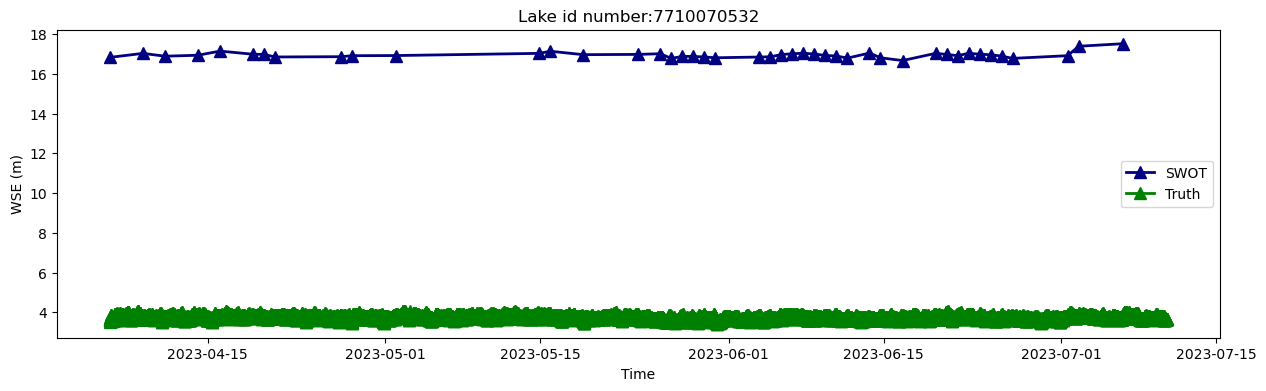

In [14]:
results_filtered = results[(results['quality_f']==0)]
truth_filtered = truth[(truth['_time'] > np.min(results['_time'])) & (truth['_time'] < np.max(results['_time']))]


plt.figure(figsize=(15, 4))
plt.title("Lake id number:" + lake_id)
plt.ylabel("WSE (m)")
plt.xlabel("Time")

# plt.plot(results['_time'], results['wse'], marker='^', label="SWOT", markersize=8, linestyle='-', linewidth=2, color= 'navy')
plt.plot(results_filtered['_time'], results_filtered['wse'], marker='^', label="SWOT", markersize=8, linestyle='-', linewidth=2, color= 'navy')
plt.plot(truth_filtered['_time'], truth_filtered['wse'], marker='^', label="Truth", markersize=8, linestyle='-', linewidth=2, color= 'green')

plt.legend()


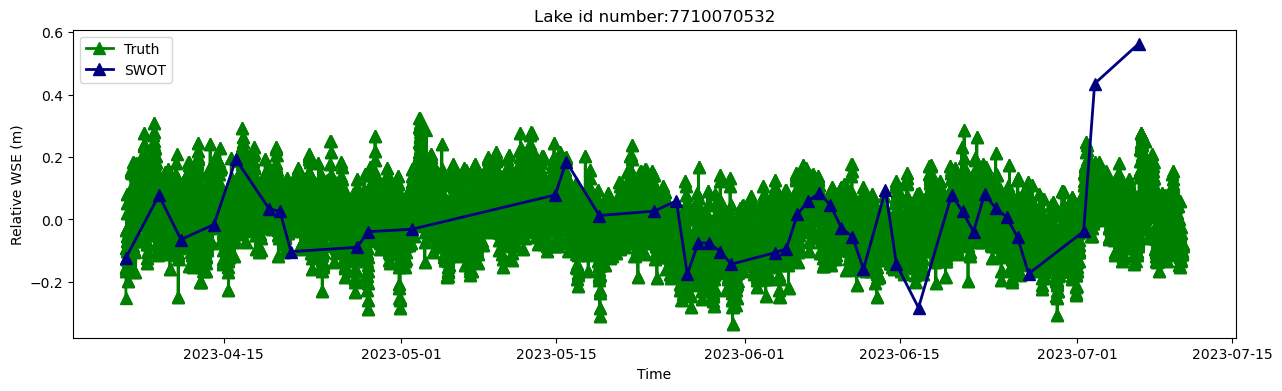

In [15]:
plt.figure(figsize=(15, 4))
plt.title("Lake id number:" + lake_id)
plt.ylabel("Relative WSE (m)")
plt.xlabel("Time")

plt.plot(truth_filtered['_time'], truth_filtered['wse']-np.mean(truth_filtered['wse']), label="Truth", marker='^', markersize=8, linestyle='-', linewidth=2, color= 'green')
plt.plot(results_filtered['_time'], results_filtered['wse']-np.mean(results_filtered['wse']), label="SWOT", marker='^', markersize=8, linestyle='-', linewidth=2, color= 'navy')
# plt.plot(results['_time'], results['quality_f'], marker='^', markersize=8, linestyle='-', label='flag', linewidth=2, color= 'red')

plt.legend()

## Example in Norway (levelled station)

In [16]:
lake_id = '2510330642' #norvege

In [17]:

results = hydro_db_api.search.search_observations(table='swot_lakesp_reproc2024_ts',
                                                  start=datetime.datetime(2023,1,1),
                                                  end=datetime.datetime(2024,1,1),
                                                 filtered_by="_fuid='{}'".format(lake_id))


truth = hydro_db_api.search.search_observations(table='truth_lake_ts',
                                                  start=datetime.datetime(2023,1,1),
                                                  end=datetime.datetime(2025,1,1),
                                                 filtered_by="_fuid LIKE 'NVE:{}'".format(lake_id))

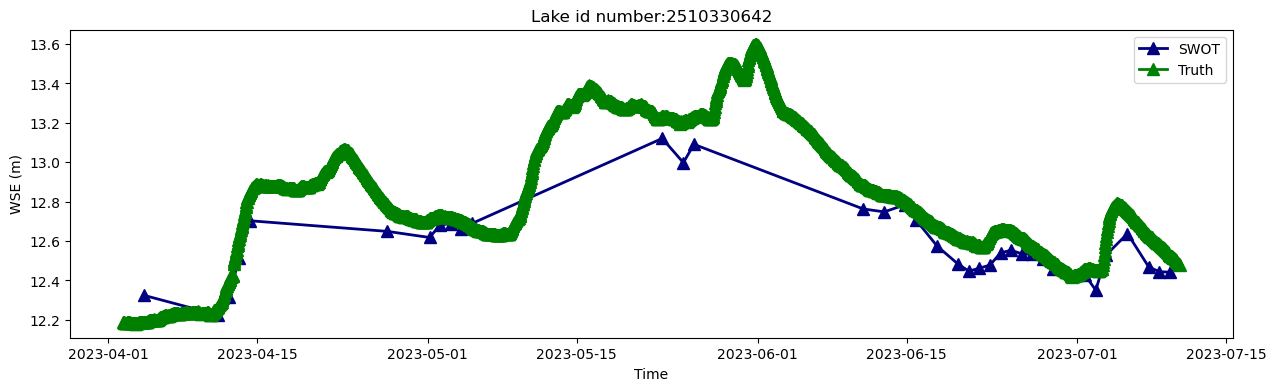

In [18]:
results_filtered = results[(results['quality_f']==0)]
truth_filtered = truth[(truth['_time'] > np.min(results['_time'])) & (truth['_time'] < np.max(results['_time']))]


plt.figure(figsize=(15, 4))
plt.title("Lake id number:" + lake_id)
plt.ylabel("WSE (m)")
plt.xlabel("Time")

# plt.plot(results['_time'], results['wse'], marker='^', label="SWOT", markersize=8, linestyle='-', linewidth=2, color= 'navy')
plt.plot(results_filtered['_time'], results_filtered['wse'], marker='^', label="SWOT", markersize=8, linestyle='-', linewidth=2, color= 'navy')
plt.plot(truth_filtered['_time'], truth_filtered['wse'], marker='^', label="Truth", markersize=8, linestyle='-', linewidth=2, color= 'green')

plt.legend()


### Plot the shape of the lake for different cycles

In [19]:
from branca.colormap import linear

minvalue, maxvalue = results_filtered['wse'].min(), results_filtered['wse'].max()
colormap = linear.YlGnBu_05.scale(minvalue, maxvalue)
colormap.caption = "wse (m)"
colormap


IMPORTANT !
The parameter "duration" represents the period during wich an observation will be visible on the map.
In the following example, duration='PT23H59M' means the observations are displayed for one day and disappear the next day of the animation. You can remove this parameter to always display observations until the next one
see ISO 8601 standard documentation


In [20]:
centroid = results_filtered.geometry.iloc[0].centroid

m = folium.Map([centroid.y,centroid.x], zoom_start=11,tiles="CartoDbPositron") 
TimestampedGeoJson(
    data=create_geojson_features(results_filtered,'wse'),
    transition_time=1000,
    auto_play=True,
    add_last_point=True,
    loop=True,
    loop_button=True,
    #duration='PT23H59M',
    date_options='YYYY-MM-DD'
).add_to(m)
m.add_child(colormap)

m


/work/softs/vre/projets/swotce/exploitation/envs/ceswot-stable/lib/python3.10/site-packages/geopandas/plotting.py:397: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


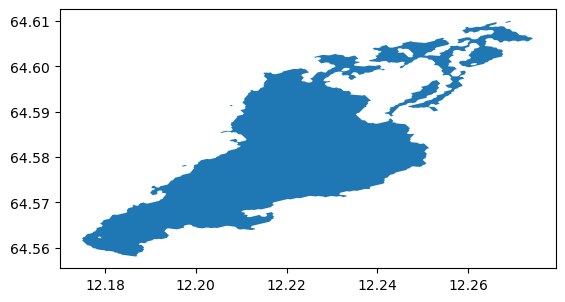

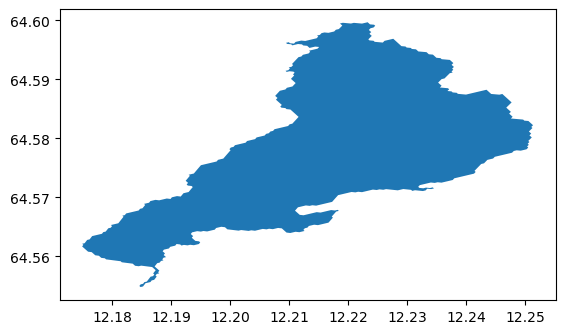

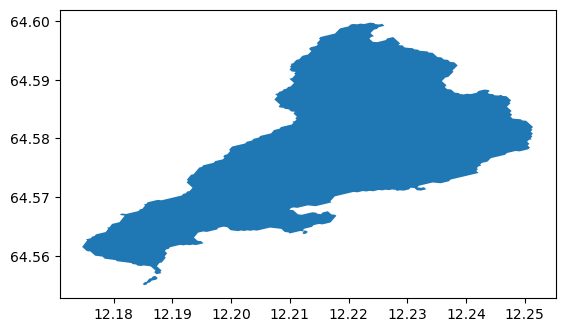

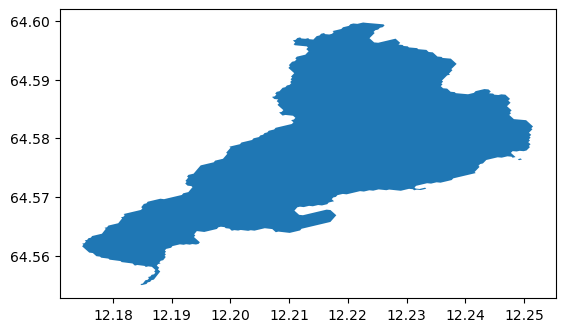

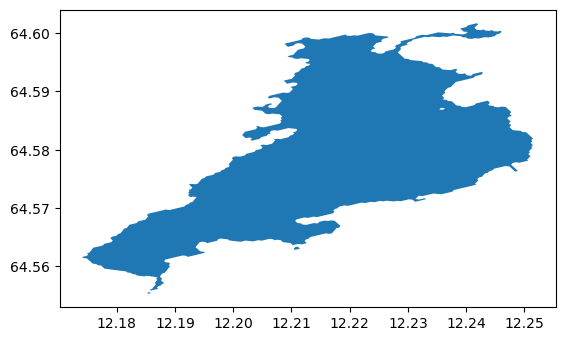

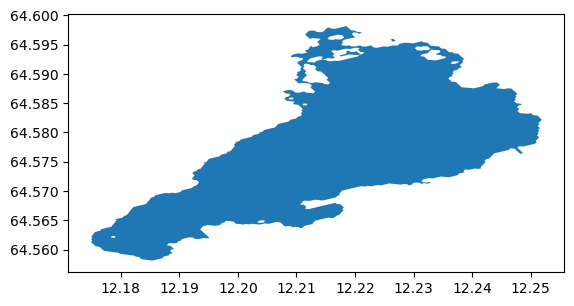

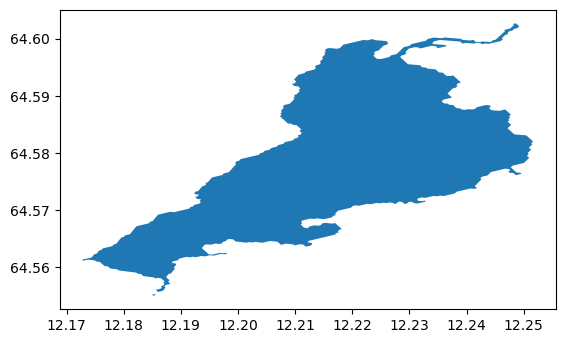

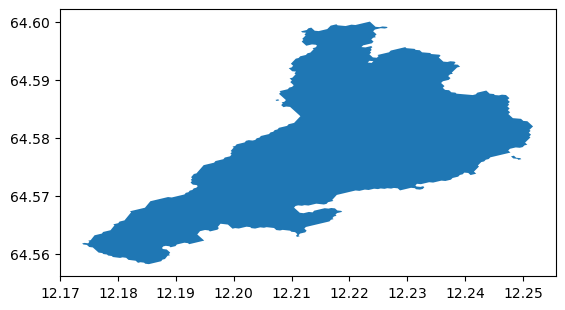

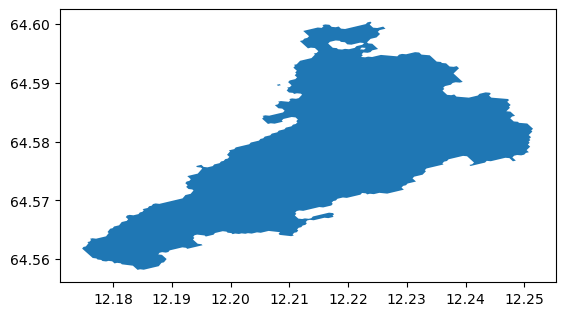

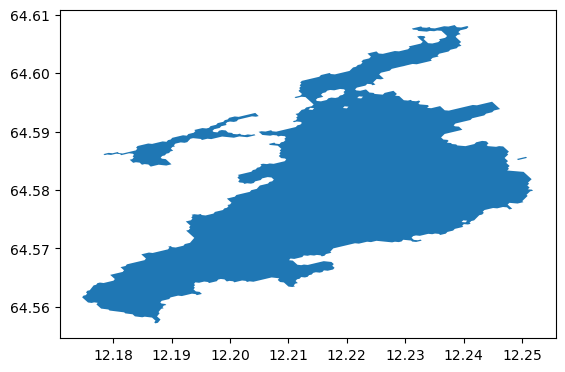

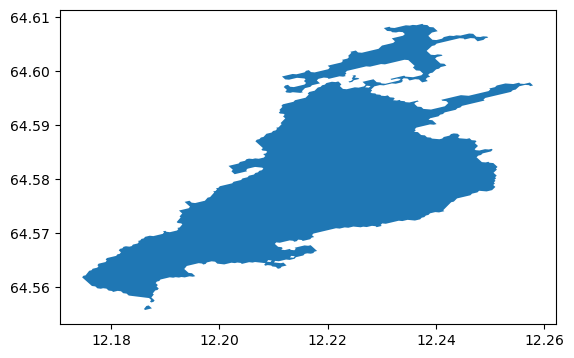

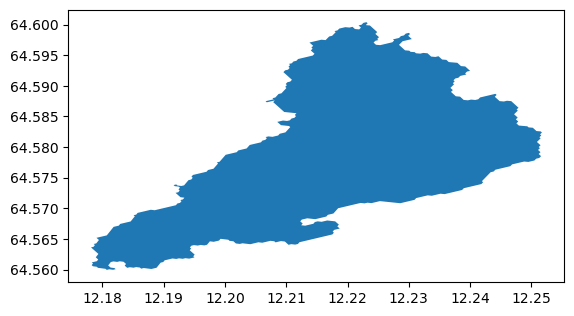

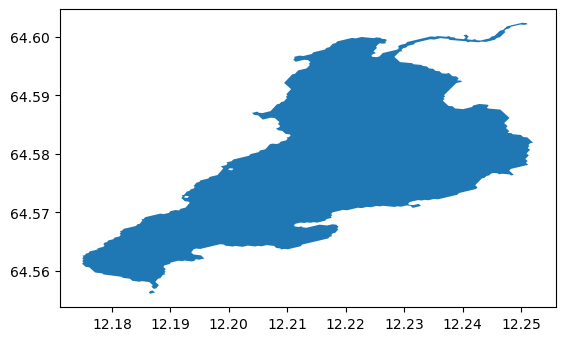

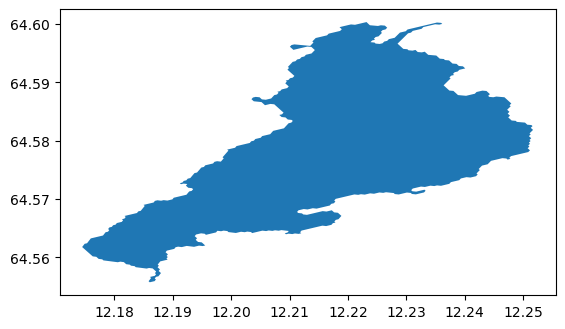

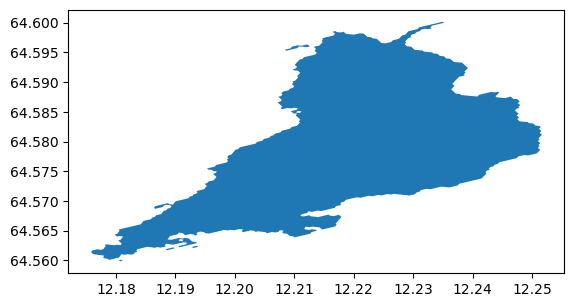

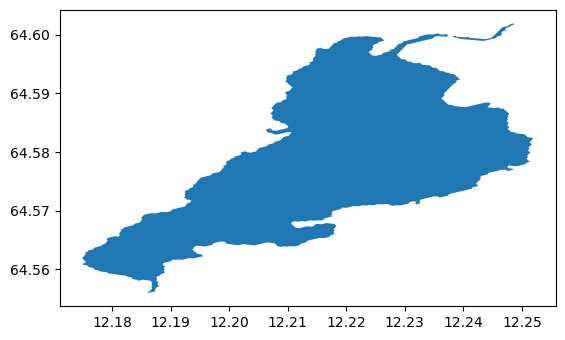

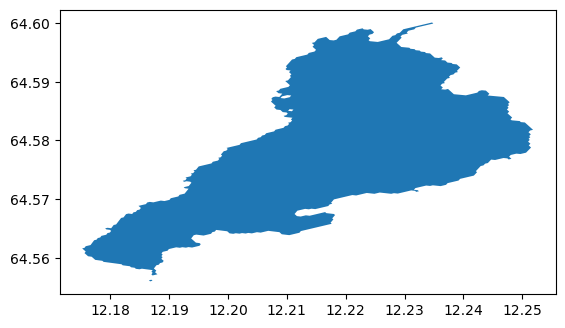

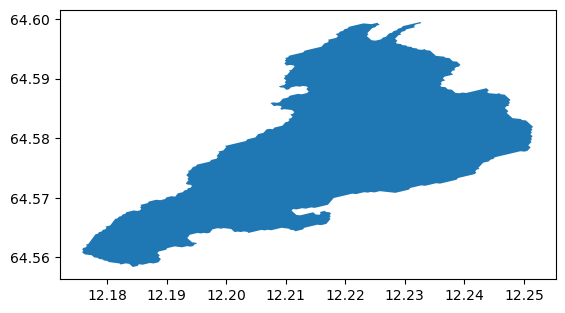

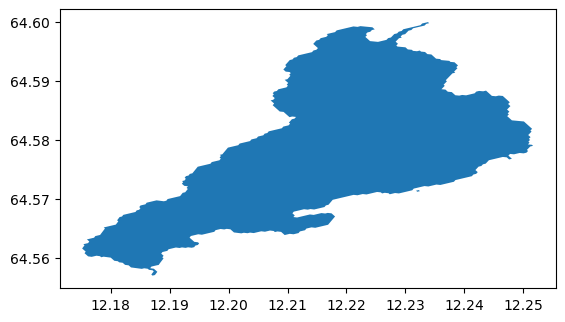

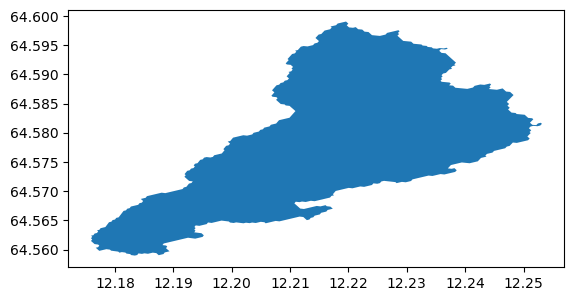

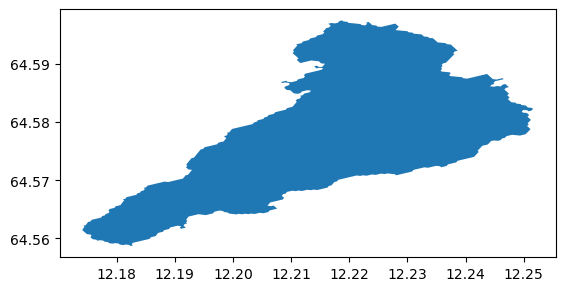

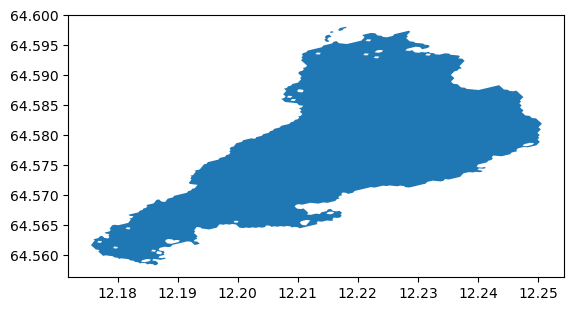

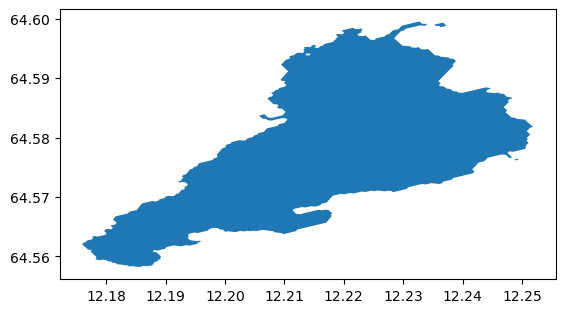

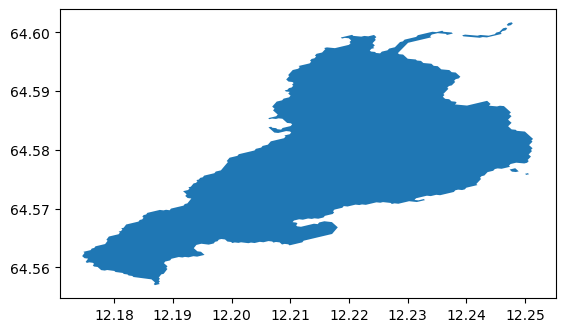

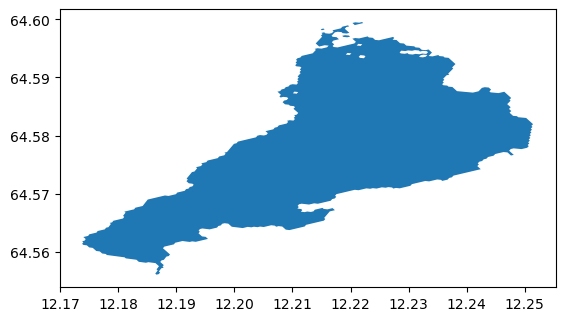

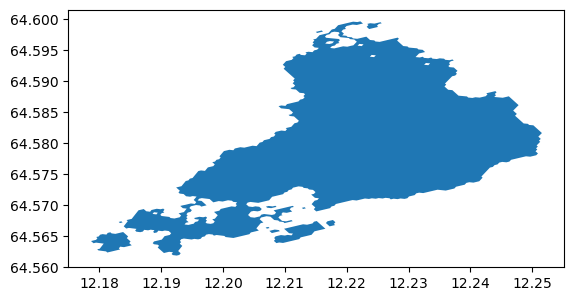

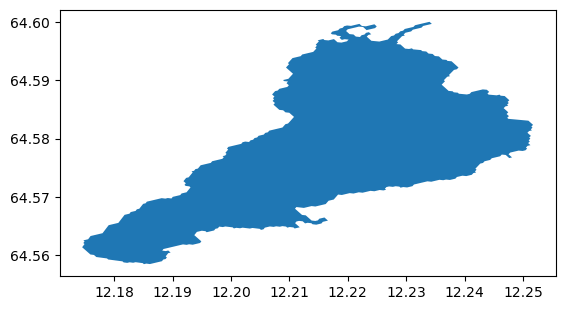

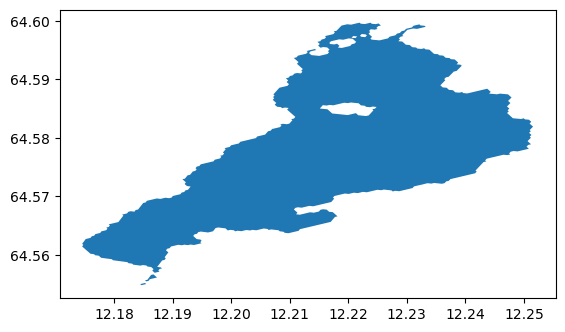

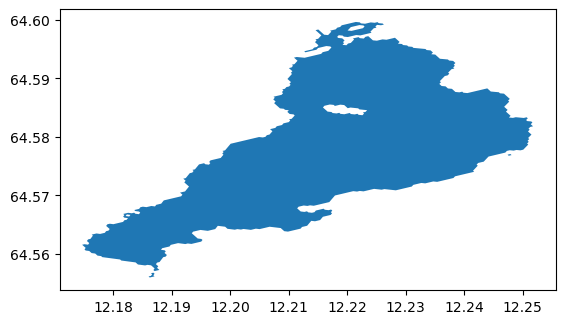

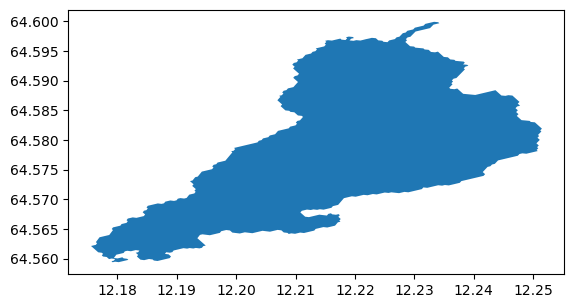

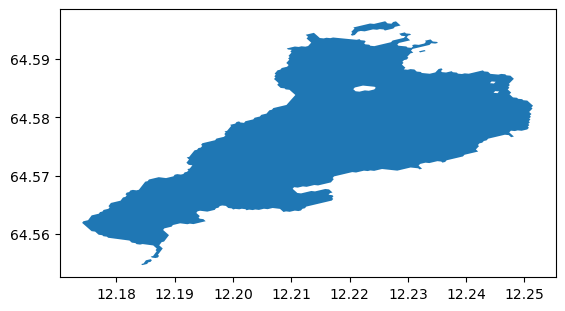

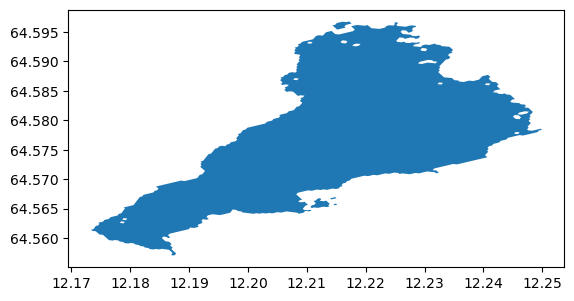

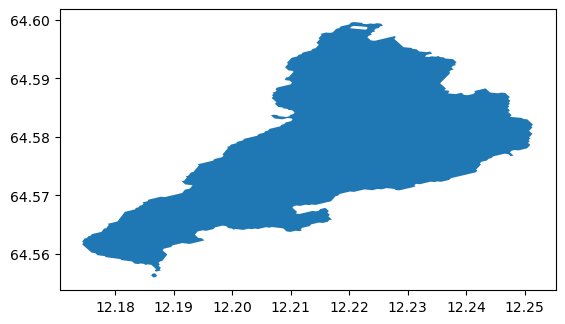

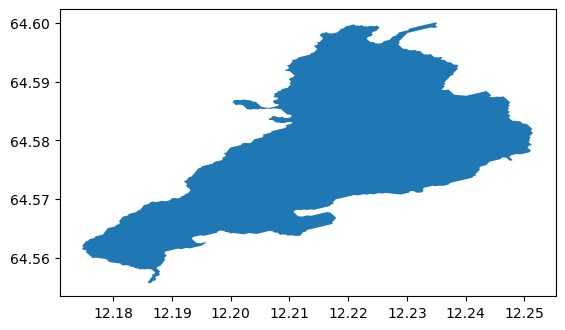

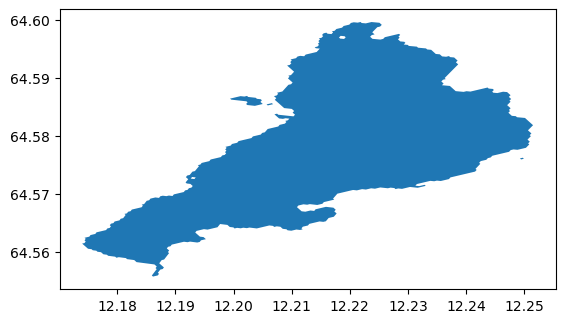

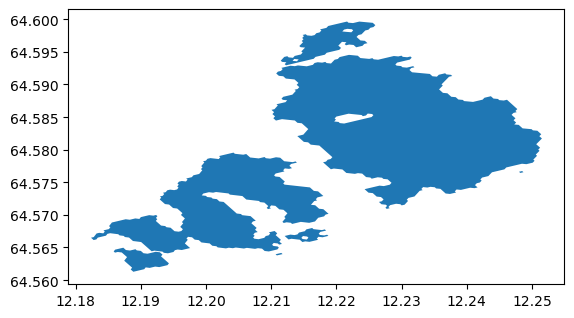

In [19]:
for i in results_filtered.index:
    results_filtered.loc[[i],'geometry'].plot()